### Test data from genderizeR project

In [1]:
import pandas as pd
import csv
import re
from helpers import clean_name_part, build_full_name

In [2]:
# This data obtained from https://github.com/kalimu/genderizeR/tree/master/data taking the authorships file, 
# opening and reading it in R Studio, exporting to csv
test_data_raw = pd.read_csv('authorships_genderizeR_paper.csv')

In [3]:
test_data_raw.head()

,Unnamed: 0,WOSaccessionNumber,title,authors,value,genderCoded
0,1,A1993LL08800024,"MCNUTT,JAMES,WESLEY - OBITUARIES","ARMSON, KA","ARMSON, KA",noname
1,2,000307797400050,GLENN PRESTWICH,"Thayer, Ann","Thayer, Ann",unknown
2,3,A19668808300004,"OBITUARY - HEVESY,GV","ERDOS, J","ERDOS, J",noname
3,4,A1994PL30300031,NIXON AND THE DISABILITY-RIGHTS MOVEMENT .2. A...,"LONGMORE, P","LONGMORE, P",noname
4,5,A1993KU74400007,"ABEL,YVES",Anonymous,Anonymous,noname


In [9]:
test_data_raw[test_data_raw.value.str.contains('ASHLEY')]

,Unnamed: 0,WOSaccessionNumber,title,authors,value,genderCoded


In [4]:
# Extract the data in the same format than the zbMATH test data",
# columns: id, raw_name, first_name, middle_name, last_name, gender",
def split_name(raw_name):
    raw_name = raw_name.lower()
    # Everything before a comma is last_name
    try:
        last_name, name = raw_name.strip().strip('.').split(',')
    except ValueError:
        name = None
        last_name, first_name, middle_name = raw_name.strip().strip('.'), None, None
    # Now parse name
    if name:
        try:
            name_parts = re.compile(r'\W').split(name.strip().strip('.'))
            first_name = name_parts[0] # first_name is only the first word",
            if len(name_parts)>=2 and len(name_parts[1]) > 1:
                middle_name = name_parts[1] # middle_name is only the second word, if exists",
            else:
                middle_name = None
        except ValueError:
            first_name, middle_name = name.strip().strip('.'), None
    return first_name, middle_name, last_name

In [23]:
gender_keys = {'noname': 'noname', 
               'unknown': 'u', 
               'male': 'm',
               'female': 'f'}

In [6]:
test_data = pd.DataFrame()

In [7]:
test_data['id'] = test_data_raw['Unnamed: 0']
test_data['raw_name'] = test_data_raw['value']
test_data['first_name'], test_data['middle_name'], test_data['last_name'] = zip(*test_data_raw['value'].map(split_name))
test_data['gender'] = test_data_raw['genderCoded'].apply(lambda n: gender_keys[n])
clean_name_part(test_data, 'first_name')
clean_name_part(test_data, 'middle_name')
build_full_name(test_data)

In [8]:
test_data.head()

,id,raw_name,first_name,middle_name,last_name,gender,full_name
0,1,"ARMSON, KA",ka,,armson,noname,ka armson
1,2,"Thayer, Ann",ann,,thayer,u,ann thayer
2,3,"ERDOS, J",,,erdos,noname,erdos
3,4,"LONGMORE, P",,,longmore,noname,longmore
4,5,Anonymous,,,anonymous,noname,anonymous


In [9]:
# How many entries with name
len(test_data[test_data.gender != 'noname'])

602

In [10]:
# Distribution of male, female, unknown labels
test_data[test_data.gender != 'noname']['gender'].value_counts()

m    346
u    165
f     91
Name: gender, dtype: int64

In [11]:
# check whether we have first names that consist of more than one word
test_data.first_name.apply(lambda n: int(len(n.split())) if n else None).unique()

array([  1.,  nan])

In [12]:
# this is an example where raw_name had more than three words separated by ' '
test_data[test_data.id==331]

,id,raw_name,first_name,middle_name,last_name,gender,full_name
330,331,"Findlay, James A. M.",james,,findlay,m,james findlay


In [13]:
test_data[(test_data.gender != 'noname')].first_name.apply(lambda n: len(n) if n else 0).value_counts()

5     138
6     136
4     109
7      91
8      41
0      28
3      27
9      25
2       3
11      2
10      2
Name: first_name, dtype: int64

In [14]:
data_to_export = test_data[(test_data.gender != 'noname') & 
                           (test_data.first_name.apply(lambda n: len(n) if n else 0) > 1)]
data_to_export.head()

,id,raw_name,first_name,middle_name,last_name,gender,full_name
1,2,"Thayer, Ann",ann,,thayer,u,ann thayer
11,12,"Chiesa, Paolo",paolo,,chiesa,m,paolo chiesa
24,25,"Abbate, Ernesto",ernesto,,abbate,m,ernesto abbate
28,29,"Epstein, John H.",john,,epstein,m,john epstein
34,35,"Cotroneo, Margaret",margaret,,cotroneo,f,margaret cotroneo


In [15]:
data_to_export[data_to_export.duplicated(subset='full_name')]

,id,raw_name,first_name,middle_name,last_name,gender,full_name
888,889,"Wang, Linda",linda,,wang,f,linda wang
1499,1500,"Wang, Linda",linda,,wang,f,linda wang
1639,1640,"Cash, Stephanie",stephanie,,cash,u,stephanie cash
1640,1641,"Ebony, David",david,,ebony,m,david ebony
1679,1680,"Ouellette, Dan",dan,,ouellette,m,dan ouellette
1778,1779,"Cash, Stephanie",stephanie,,cash,u,stephanie cash
1910,1911,"Shupnik, Margaret A.",margaret,,shupnik,m,margaret shupnik


In [16]:
data_to_export[data_to_export.last_name=='wang']

,id,raw_name,first_name,middle_name,last_name,gender,full_name
485,486,"Wang, Linda",linda,,wang,f,linda wang
888,889,"Wang, Linda",linda,,wang,f,linda wang
1499,1500,"Wang, Linda",linda,,wang,f,linda wang


In [17]:
len(data_to_export)

574

In [18]:
len(data_to_export.drop_duplicates(subset='full_name'))

567

In [19]:
data_to_export = data_to_export.drop_duplicates(subset='full_name')

### Manual corrections

In [20]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)

#### Males

In [21]:
data_to_export[data_to_export.gender=='m']

,id,raw_name,first_name,middle_name,last_name,gender,full_name
11,12,"Chiesa, Paolo",paolo,,chiesa,m,paolo chiesa
24,25,"Abbate, Ernesto",ernesto,,abbate,m,ernesto abbate
28,29,"Epstein, John H.",john,,epstein,m,john epstein
39,40,"Simoni, Robert D.",robert,,simoni,m,robert simoni
40,41,"Hill, Robert L.",robert,,hill,m,robert hill
77,78,"Watts, Geoff",geoff,,watts,m,geoff watts
89,90,"Burkhardt, Gerhard",gerhard,,burkhardt,m,gerhard burkhardt
92,93,"Ebony, David",david,,ebony,m,david ebony
93,94,"Cooper, Martin",martin,,cooper,m,martin cooper
105,106,"Whittall, Arnold",arnold,,whittall,m,arnold whittall


Here's an error in the parsing of the author list -- see https://archive.monthlyreview.org/index.php/mr/article/view/MR-058-05-2006-09_10

In [22]:
test_data_raw.iloc[1407]

Unnamed: 0            1408                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
WOSaccessionNumber    000240878400010                                                                                                                                                                                                                                                                                         

In [23]:
data_to_export[data_to_export.id==1407]

,id,raw_name,first_name,middle_name,last_name,gender,full_name
1406,1407,"Amin, Samir Isabelle",samir,isabelle,amin,m,samir isabelle amin


In [24]:
data_to_export.loc[1406, 'middle_name'] = ''
data_to_export.loc[1406, 'raw_name'] = 'Amin, Samir'
data_to_export.loc[1406, 'full_name'] = 'samir amin'

In [25]:
data_to_export[data_to_export.id==1407]

,id,raw_name,first_name,middle_name,last_name,gender,full_name
1406,1407,"Amin, Samir",samir,,amin,m,samir amin


This person is 'f': http://spiff.ucsd.edu/sharon.old.html

In [26]:
test_data_raw.iloc[2167]

Unnamed: 0            2168                
WOSaccessionNumber    000281752200021     
title                 SHARON E.R. FRANKS  
authors               Franks, Sharon E. R.
value                 Franks, Sharon E. R.
genderCoded           male                
Name: 2167, dtype: object

In [27]:
data_to_export[data_to_export.id==2168]

,id,raw_name,first_name,middle_name,last_name,gender,full_name
2167,2168,"Franks, Sharon E. R.",sharon,,franks,m,sharon franks


In [28]:
data_to_export.loc[2167, 'gender'] = 'f'

In [29]:
data_to_export[data_to_export.id==2168]

,id,raw_name,first_name,middle_name,last_name,gender,full_name
2167,2168,"Franks, Sharon E. R.",sharon,,franks,f,sharon franks


This is also 'f': https://www.linkedin.com/in/arlene-goldberg-gist-138a21a/

In [30]:
test_data_raw.iloc[2629]

Unnamed: 0            2630                                                          
WOSaccessionNumber    000275147600052                                               
title                 GEORGE C. PIMENTEL AWARD IN CHEMICAL EDUCATION Zafra J. Lerman
authors               Goldberg-Gist, Arlene                                         
value                 Goldberg-Gist, Arlene                                         
genderCoded           male                                                          
Name: 2629, dtype: object

In [31]:
data_to_export[data_to_export.id==2630]

,id,raw_name,first_name,middle_name,last_name,gender,full_name
2629,2630,"Goldberg-Gist, Arlene",arlene,,goldberg-gist,m,arlene goldberg-gist


In [32]:
data_to_export.loc[2629, 'gender'] = 'f'

In [33]:
data_to_export[data_to_export.id==2630]

,id,raw_name,first_name,middle_name,last_name,gender,full_name
2629,2630,"Goldberg-Gist, Arlene",arlene,,goldberg-gist,f,arlene goldberg-gist


#### Females

In [34]:
data_to_export[data_to_export.gender=='f']

,id,raw_name,first_name,middle_name,last_name,gender,full_name
34,35,"Cotroneo, Margaret",margaret,,cotroneo,f,margaret cotroneo
38,39,"Kresge, Nicole",nicole,,kresge,f,nicole kresge
59,60,"Williams, Ruth",ruth,,williams,f,ruth williams
91,92,"Cash, Stephanie",stephanie,,cash,f,stephanie cash
103,104,"Clarke, Mary",mary,,clarke,f,mary clarke
193,194,"Raber, Linda",linda,,raber,f,linda raber
195,196,"Waters, Hannah",hannah,,waters,f,hannah waters
206,207,"Shupnik, Margaret A.",margaret,,shupnik,f,margaret shupnik
228,229,"Luke, Andrea",andrea,,luke,f,andrea luke
230,231,"Kraus, Lisa",lisa,,kraus,f,lisa kraus


This is 'm': https://twitter.com/nljubesic

In [35]:
data_to_export.loc[2449]

id             2450            
raw_name       Ljubesic, Nikola
first_name     nikola          
middle_name                    
last_name      ljubesic        
gender         f               
full_name      nikola ljubesic 
Name: 2449, dtype: object

In [36]:
data_to_export.loc[2449, 'gender'] = 'm'

In [37]:
data_to_export.loc[2449]

id             2450            
raw_name       Ljubesic, Nikola
first_name     nikola          
middle_name                    
last_name      ljubesic        
gender         m               
full_name      nikola ljubesic 
Name: 2449, dtype: object

### Store in CSV files

In [38]:
# This file can be used to evaluate other name-based inference services
data_to_export.to_csv("test_data_genderizeR.csv", 
                       columns=["raw_name", "first_name", "middle_name", "last_name", "full_name", "gender"],
                       quoting=csv.QUOTE_ALL,
                       index=False)

### Titles data

In [4]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 600)

In [5]:
test_data_raw2 = pd.read_csv('titles_genderizeR_paper.csv')

In [6]:
test_data_raw2.head(10)

,Unnamed: 0,title,genderCoded
0,1,"""A friend to man,"" Dr. Feifan Tang: a story of causative agent of trachoma, from ""Tang's virus"" to Chlamydia trachomatis, to ""Phylum Chlamydiae""",male
1,2,'I'll Never Sing With a Dance Band Again'-Holiday,none
2,3,"(Jacqueline) Nancy Mary Adams, CBE, QSO 1926-2007",female
3,4,"1779-1796: In Torino, Dom Rodrigo de Souza Coutinho, Portugese, future count of Linhares is minister for state",male
4,5,1991 RECIPIENT OF THE CLAY MINERALS SOCIETY DISTINGUISHED MEMBER AWARD JOE B. DIXON,male
5,6,1999 Visiting Research Professorship and Young Investigator Award - The 1999 CAG Visiting Research Professorship - Dr Lloyd R Sutherland,male
6,7,"2001 Distinguished Scientific Achievement Award - Presented to John H. Hubbell - At the 46th Annual Meeting of the Health Physics Society, Cleveland, OH - 10-14 June 2001",male
7,8,2003 grand prize winner,none
8,9,2005 R W P King Award - Robert J. Adams,male
9,10,"2006 Robley D. Evans Commemorative Medal - Presented to Ludwig Feinendegen at the 51st Annual Meeting of the Health Physics Society, Providence, Rhode Island - 25-29 June 2006",male


In [7]:
import nltk
# Uncomment and run this if you're missing the nltk_data files, corpora, etc
# nltk.download()

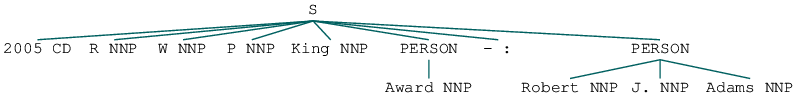

In [8]:
# Names extractor based on nltk's POS tagger
# Tagger makes some errors - see Award below classified as PERSON - we'll filter that later
s = '2005 R W P King Award - Robert J. Adams'
nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(s)))

In [9]:
def extract_persons(text):
    if text.isupper():
        text = text.title()
    persons = []
    last_per = -1000
    for sent in nltk.sent_tokenize(text):
        # Remove parentheses
        text = text.replace('(', '').replace(')', '')
        for i, chunk in enumerate(nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sent)))):
            if hasattr(chunk, 'label') and chunk.label()=='PERSON':
                # If we find two consecutive chunks labelled as PERSON we'll merge them
                if i == last_per + 1:
                    persons.append(person + ' ' + ' '.join(c[0] for c in chunk.leaves()))
                else:
                    person = ' '.join(c[0] for c in chunk.leaves())
                    persons.append(person)
                last_per = i
    return persons

def select_persons(candidates):
    bad_words = ['award', 'obituary', 'medal', 'record', 'memorial', 'academic', 'practitioner', 'medieval', 
                 'member', 'obe', 'mb', 'bs', 'phd', 'acta', 'ac', 'memoriam', 'father', 'cancer', 'memoirs',
                 'sir', 'prize', 'lecturer', 'death', 'opinion', 'radiologist', 'professor']
    # Filter candidates that do not contain words above:
    candidates = [c for c in candidates if not any(word in c.lower() for word in bad_words)]
    # Remove names with only one element
    candidates = [c for c in candidates if len(c.split()) > 1]
    # Selecting only when we extracted one candidate
    return candidates[0].title() if len(candidates) == 1 else None

In [10]:
test_data_raw2['raw_name'] = test_data_raw2.title.apply(lambda t: select_persons(extract_persons(t)))

In [11]:
len(test_data_raw2[test_data_raw2.genderCoded.isin(['male', 'female'])])

1145

In [12]:
len(test_data_raw2[(~test_data_raw2.raw_name.isnull()) & (test_data_raw2.genderCoded.isin(['male', 'female']))])

504

In [13]:
test_data2 = test_data_raw2[(~test_data_raw2.raw_name.isnull()) & (test_data_raw2.genderCoded.isin(['male', 'female']))]
test_data2

,Unnamed: 0,title,genderCoded,raw_name
2,3,"(Jacqueline) Nancy Mary Adams, CBE, QSO 1926-2007",female,Nancy Mary Adams
5,6,1999 Visiting Research Professorship and Young Investigator Award - The 1999 CAG Visiting Research Professorship - Dr Lloyd R Sutherland,male,Lloyd R Sutherland
6,7,"2001 Distinguished Scientific Achievement Award - Presented to John H. Hubbell - At the 46th Annual Meeting of the Health Physics Society, Cleveland, OH - 10-14 June 2001",male,John H. Hubbell
10,11,2008 Barringer Medal for Frank Kyte,male,Frank Kyte
12,13,60th Birthday of professor Nobuo Tanaka,male,Nobuo Tanaka
14,15,90th anniversary of professor Jaroslav Krejci.,male,Jaroslav Krejci
15,16,"A Chinese palaeontologist, Ma Ting Ying (1899-1979): From coral growth-rings to global tectonics",male,Ma Ting Ying
17,18,"A Tribute to Donald M. Britton (1923-2012), Canada's Premier Pteridologist",male,Donald M. Britton
18,19,A Tribute to Judge William Wayne Justice,male,William Wayne
20,21,A heroic law teacher: Dean Leonard Gering,male,Dean Leonard Gering


Check manually correct extraction of names. Discard obvious errors

In [14]:
wrong_ids = [21, 99, 103, 112, 175, 187, 194, 203, 259, 260, 321, 336, 340, 369, 430, 480, 493, 543, 594, 
             623, 643, 648, 651, 662, 750, 815, 942, 1009, 1034, 1049, 1050, 1077, 11184]

In [15]:
test_data2[test_data2['Unnamed: 0'].isin(wrong_ids)]

,Unnamed: 0,title,genderCoded,raw_name
20,21,A heroic law teacher: Dean Leonard Gering,male,Dean Leonard Gering
98,99,"Anthony Martin Halliday, BSc, MB, ChB, FRCP, FBCS (1926-2008) - Obituary",male,Anthony Martin
102,103,Antony John Essex-Cater OBITUARY,male,Antony John
111,112,Arturo Davila S.,male,Arturo Davila S
174,175,Carl Christoph von Hoffmann (1735-1801) forgotten pioneer of beet sugar industry,male,Carl Christoph
186,187,"Charles Everett Koop MD, DSc October 16, 1916-February 25, 2013 Obituary",male,Charles Everett Koop Md
193,194,Citation for honorary member of the association of engineering geologists - Richard James Proctor,male,Richard James
202,203,Clarence Lavett Smith,male,Lavett Smith
258,259,Distinguished New Zealand Geographer: Professor James Anthony (Tony) Binns,male,James Anthony
259,260,Domenico Menotti Garibaldi,male,Menotti Garibaldi


In [16]:
len(test_data2)

504

In [17]:
test_data2 = test_data2[~test_data2['Unnamed: 0'].isin(wrong_ids)]

In [18]:
len(test_data2)

472

In [19]:
len(wrong_ids)

33

In [20]:
test_data_titles = pd.DataFrame()

In [21]:
def split_names(raw_name):
    raw_name = raw_name.lower()
    surname, names = raw_name.split()[-1], ' '.join(raw_name.split()[:-1])
    first_name, rest = names.split()[0].strip('.'), ' '.join(names.split()[1:])
    if rest:
        middle_name = rest.split()[0].strip('.')
    else:
        middle_name = None
    return first_name, middle_name, surname

In [24]:
test_data_titles['id'] = test_data2['Unnamed: 0']
test_data_titles['raw_name'] = test_data2['raw_name']
test_data_titles['first_name'], test_data_titles['middle_name'], test_data_titles['last_name'] = zip(*test_data2['raw_name'].map(split_names))
test_data_titles['full_name'] = test_data2['raw_name'].apply(lambda n: n.lower())
test_data_titles['gender'] = test_data2['genderCoded'].apply(lambda n: gender_keys[n])
clean_name_part(test_data_titles, 'first_name')
clean_name_part(test_data_titles, 'middle_name')

In [25]:
test_data_titles.head()

,id,raw_name,first_name,middle_name,last_name,full_name,gender
2,3,Nancy Mary Adams,nancy,mary,adams,nancy mary adams,f
5,6,Lloyd R Sutherland,lloyd,,sutherland,lloyd r sutherland,m
6,7,John H. Hubbell,john,,hubbell,john h. hubbell,m
10,11,Frank Kyte,frank,,kyte,frank kyte,m
12,13,Nobuo Tanaka,nobuo,,tanaka,nobuo tanaka,m


In [26]:
# How many entries with name
len(test_data_titles)

472

In [27]:
# Distribution of male, female, unknown labels
test_data_titles['gender'].value_counts()

m    414
f    58 
Name: gender, dtype: int64

In [28]:
# check whether we have first names that consist of more than one word
test_data_titles.first_name.apply(lambda n: int(len(n.split())) if n else None).unique()

array([1])

In [29]:
test_data_titles.first_name.apply(lambda n: len(n) if n else 0).value_counts()

6     113
5     107
7     90 
4     89 
8     31 
9     22 
3     15 
10    2  
2     2  
11    1  
Name: first_name, dtype: int64

In [30]:
test_data_titles[test_data_titles.duplicated(subset='full_name')]

,id,raw_name,first_name,middle_name,last_name,full_name,gender
1132,1133,Ursula Vaughan Williams,ursula,vaughan,williams,ursula vaughan williams,f


In [31]:
test_data_titles = test_data_titles.drop_duplicates(subset='full_name')

In [32]:
test_data_titles = test_data_titles.fillna('')

Manual corrections

In [33]:
test_data_titles[test_data_titles.gender=='f']

,id,raw_name,first_name,middle_name,last_name,full_name,gender
2,3,Nancy Mary Adams,nancy,mary,adams,nancy mary adams,f
57,58,Shelley Winters,shelley,,winters,shelley winters,f
88,89,Anna Isabella Davison,anna,isabella,davison,anna isabella davison,f
91,92,Anne Mary Buck,anne,mary,buck,anne mary buck,f
116,117,Diane F. Halpern,diane,,halpern,diane f. halpern,f
117,118,Jeannette J. Townsend,jeannette,,townsend,jeannette j. townsend,f
168,169,Judith S. Kaye,judith,,kaye,judith s. kaye,f
177,178,Carla Gavazzi,carla,,gavazzi,carla gavazzi,f
195,196,Lisa H. Fish,lisa,,fish,lisa h. fish,f
257,258,Paivi Astedt-Kurki,paivi,,astedt-kurki,paivi astedt-kurki,f


In [34]:
test_data_titles.loc[317]

id             318                     
raw_name       Elizabeth Parkinson Cobb
first_name     elizabeth               
middle_name    parkinson               
last_name      cobb                    
full_name      elizabeth parkinson cobb
gender         f                       
Name: 317, dtype: object

In [35]:
test_data_titles.loc[317, 'middle_name'] = ''
test_data_titles.loc[317, 'last_name'] = 'parkinson cobb'
test_data_titles.loc[317]

id             318                     
raw_name       Elizabeth Parkinson Cobb
first_name     elizabeth               
middle_name                            
last_name      parkinson cobb          
full_name      elizabeth parkinson cobb
gender         f                       
Name: 317, dtype: object

In [36]:
test_data_titles.loc[1131]

id             1132                   
raw_name       Ursula Vaughan Williams
first_name     ursula                 
middle_name    vaughan                
last_name      williams               
full_name      ursula vaughan williams
gender         f                      
Name: 1131, dtype: object

In [37]:
test_data_titles.loc[1131, 'middle_name'] = ''
test_data_titles.loc[1131, 'last_name'] = 'vaughan williams'
test_data_titles.loc[1131]

id             1132                   
raw_name       Ursula Vaughan Williams
first_name     ursula                 
middle_name                           
last_name      vaughan williams       
full_name      ursula vaughan williams
gender         f                      
Name: 1131, dtype: object

In [38]:
test_data_titles[test_data_titles.gender=='m']

,id,raw_name,first_name,middle_name,last_name,full_name,gender
5,6,Lloyd R Sutherland,lloyd,,sutherland,lloyd r sutherland,m
6,7,John H. Hubbell,john,,hubbell,john h. hubbell,m
10,11,Frank Kyte,frank,,kyte,frank kyte,m
12,13,Nobuo Tanaka,nobuo,,tanaka,nobuo tanaka,m
14,15,Jaroslav Krejci,jaroslav,,krejci,jaroslav krejci,m
15,16,Ma Ting Ying,ma,ting,ying,ma ting ying,m
17,18,Donald M. Britton,donald,,britton,donald m. britton,m
18,19,William Wayne,william,,wayne,william wayne,m
21,22,Wolfram Steude,wolfram,,steude,wolfram steude,m
22,23,Winfried Schlepphorst,winfried,,schlepphorst,winfried schlepphorst,m


In [39]:
test_data_titles.loc[15]

id             16          
raw_name       Ma Ting Ying
first_name     ma          
middle_name    ting        
last_name      ying        
full_name      ma ting ying
gender         m           
Name: 15, dtype: object

In [40]:
test_data_titles.loc[15, 'middle_name'] = ''
test_data_titles.loc[15, 'last_name'] = 'ting ying'
test_data_titles.loc[15]

id             16          
raw_name       Ma Ting Ying
first_name     ma          
middle_name                
last_name      ting ying   
full_name      ma ting ying
gender         m           
Name: 15, dtype: object

In [41]:
test_data_titles.loc[260]

id             261          
raw_name       Don Van Vliet
first_name     don          
middle_name    van          
last_name      vliet        
full_name      don van vliet
gender         m            
Name: 260, dtype: object

In [42]:
test_data_titles.loc[260, 'middle_name'] = ''
test_data_titles.loc[260, 'last_name'] = 'van vliet'
test_data_titles.loc[260]

id             261          
raw_name       Don Van Vliet
first_name     don          
middle_name                 
last_name      van vliet    
full_name      don van vliet
gender         m            
Name: 260, dtype: object

In [43]:
test_data_titles.loc[308]

id             309             
raw_name       Edward De Maeyer
first_name     edward          
middle_name    de              
last_name      maeyer          
full_name      edward de maeyer
gender         m               
Name: 308, dtype: object

In [44]:
test_data_titles.loc[308, 'middle_name'] = ''
test_data_titles.loc[308, 'last_name'] = 'de maeyer'
test_data_titles.loc[308]

id             309             
raw_name       Edward De Maeyer
first_name     edward          
middle_name                    
last_name      de maeyer       
full_name      edward de maeyer
gender         m               
Name: 308, dtype: object

In [45]:
test_data_titles.loc[605]

id             606                   
raw_name       Jose Goyanes Capdevila
first_name     jose                  
middle_name    goyanes               
last_name      capdevila             
full_name      jose goyanes capdevila
gender         m                     
Name: 605, dtype: object

In [46]:
test_data_titles.loc[605, 'middle_name'] = ''
test_data_titles.loc[605, 'last_name'] = 'goyanes capdevila'
test_data_titles.loc[605]

id             606                   
raw_name       Jose Goyanes Capdevila
first_name     jose                  
middle_name                          
last_name      goyanes capdevila     
full_name      jose goyanes capdevila
gender         m                     
Name: 605, dtype: object

In [47]:
test_data_titles.loc[854]

id             855              
raw_name       Jose Ibanez Cerda
first_name     jose             
middle_name    ibanez           
last_name      cerda            
full_name      jose ibanez cerda
gender         m                
Name: 854, dtype: object

In [48]:
test_data_titles.loc[854, 'middle_name'] = ''
test_data_titles.loc[854, 'last_name'] = 'ibanez cerda'
test_data_titles.loc[854]

id             855              
raw_name       Jose Ibanez Cerda
first_name     jose             
middle_name                     
last_name      ibanez cerda     
full_name      jose ibanez cerda
gender         m                
Name: 854, dtype: object

In [49]:
test_data_titles.loc[866]

id             867             
raw_name       Herman De Pooter
first_name     herman          
middle_name    de              
last_name      pooter          
full_name      herman de pooter
gender         m               
Name: 866, dtype: object

In [50]:
test_data_titles.loc[866, 'middle_name'] = ''
test_data_titles.loc[866, 'last_name'] = 'de pooter'
test_data_titles.loc[866]

id             867             
raw_name       Herman De Pooter
first_name     herman          
middle_name                    
last_name      de pooter       
full_name      herman de pooter
gender         m               
Name: 866, dtype: object

In [51]:
test_data_titles.loc[1060]

id             1061              
raw_name       Stephen Dal Nogare
first_name     stephen           
middle_name    dal               
last_name      nogare            
full_name      stephen dal nogare
gender         m                 
Name: 1060, dtype: object

In [52]:
test_data_titles.loc[1060, 'middle_name'] = ''
test_data_titles.loc[1060, 'last_name'] = 'dal nogare'
test_data_titles.loc[1060]

id             1061              
raw_name       Stephen Dal Nogare
first_name     stephen           
middle_name                      
last_name      dal nogare        
full_name      stephen dal nogare
gender         m                 
Name: 1060, dtype: object

In [53]:
test_data_titles[test_data_titles.duplicated(subset='full_name')]

,id,raw_name,first_name,middle_name,last_name,full_name,gender


### Store in CSV files

In [54]:
# This file can be used to evaluate other name-based inference services
test_data_titles.to_csv("test_data_genderizeR_titles.csv", 
                       columns=["raw_name", "first_name", "middle_name", "last_name", "full_name", "gender"],
                       quoting=csv.QUOTE_ALL,
                       index=False)